# Predicting Customer Propensity to Churn 

##1. Installing and Importing Libraries

In [159]:
!pip install lightgbm
!pip install datetime
!pip install plotly
!pip install imblearn
!pip install fast_ml
!pip install xgboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fast_ml.utilities import display_all
from fast_ml import eda
from plotly.offline import init_notebook_mode, iplot
from plotly import tools
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
import datetime as dt
from scipy import stats
from sklearn.covariance import EllipticEnvelope
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
import pickle

##2. Data Loading & Analysis

In [2]:
orders_df = pd.read_csv('olist_orders_dataset.csv', engine='python')
order_items = pd.read_csv('olist_order_items_dataset.csv', engine='python')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', engine='python')
products = pd.read_csv('olist_products_dataset.csv', engine='python')
product_category = pd.read_csv('product_category_name_translation.csv', engine='python')
customer = pd.read_csv('olist_customers_dataset.csv', engine='python')
payments = pd.read_csv('olist_order_payments_dataset.csv', engine='python')
sellers = pd.read_csv('olist_sellers_dataset.csv', engine='python')

In [3]:
orders_df

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [4]:
order_items.head(10)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
5,00048cc3ae777c65dbb7d2a0634bc1ea,1,ef92defde845ab8450f9d70c526ef70f,6426d21aca402a131fc0a5d0960a3c90,2017-05-23 03:55:27,21.90,12.69
6,00054e8431b9d7675808bcb819fb4a32,1,8d4f2bb7e93e6710a28f34fa83ee7d28,7040e82f899a04d1b434b795a43b4617,2017-12-14 12:10:31,19.90,11.85
7,000576fe39319847cbb9d288c5617fa6,1,557d850972a7d6f792fd18ae1400d9b6,5996cddab893a4652a15592fb58ab8db,2018-07-10 12:30:45,810.00,70.75
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
9,0005f50442cb953dcd1d21e1fb923495,1,4535b0e1091c278dfd193e5a1d63b39f,ba143b05f0110f0dc71ad71b4466ce92,2018-07-06 14:10:56,53.99,11.40


In [5]:
order_reviews.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
5,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37
6,07f9bee5d1b850860defd761afa7ff16,e48aa0d2dcec3a2e87348811bcfdf22b,5,NaN,NaN,2017-07-16 00:00:00,2017-07-18 19:30:34
7,7c6400515c67679fbee952a7525281ef,c31a859e34e3adac22f376954e19b39d,5,NaN,NaN,2018-08-14 00:00:00,2018-08-14 21:36:06
8,a3f6f7f6f433de0aefbb97da197c554c,9c214ac970e84273583ab523dfafd09b,5,NaN,NaN,2017-05-17 00:00:00,2017-05-18 12:05:37
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,4,recomendo,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47


In [6]:
products.head(10)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
5,41d3672d4792049fa1779bb35283ed13,instrumentos_musicais,60.0,745.0,1.0,200.0,38.0,5.0,11.0
6,732bd381ad09e530fe0a5f457d81becb,cool_stuff,56.0,1272.0,4.0,18350.0,70.0,24.0,44.0
7,2548af3e6e77a690cf3eb6368e9ab61e,moveis_decoracao,56.0,184.0,2.0,900.0,40.0,8.0,40.0
8,37cc742be07708b53a98702e77a21a02,eletrodomesticos,57.0,163.0,1.0,400.0,27.0,13.0,17.0
9,8c92109888e8cdf9d66dc7e463025574,brinquedos,36.0,1156.0,1.0,600.0,17.0,10.0,12.0


In [7]:
products.dtypes

product_id                     object
product_category_name          object
product_name_lenght           float64
product_description_lenght    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

In [8]:
product_category.head(10)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


In [9]:
product_category.dtypes

product_category_name            object
product_category_name_english    object
dtype: object

In [10]:
customer.head(10)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,timoteo,MG
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,curitiba,PR
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,belo horizonte,MG


In [11]:
payments.head(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45
5,298fcdf1f73eb413e4d26d01b25bc1cd,1,credit_card,2,96.12
6,771ee386b001f06208a7419e4fc1bbd7,1,credit_card,1,81.16
7,3d7239c394a212faae122962df514ac7,1,credit_card,3,51.84
8,1f78449c87a54faf9e96e88ba1491fa9,1,credit_card,6,341.09
9,0573b5e23cbd798006520e1d5b4c6714,1,boleto,1,51.95


In [12]:
categories = products.merge(product_category, on = 'product_category_name', how = 'left')

In [13]:
categories

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,housewares
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0,furniture_decor
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0,construction_tools_lights
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0,bed_bath_table
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0,computers_accessories


In [14]:
sellers.head(10)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE
7,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP
8,768a86e36ad6aae3d03ee3c6433d61df,1529,sao paulo,SP
9,ccc4bbb5f32a6ab2b7066a4130f114e3,80310,curitiba,PR


In [15]:
orders = pd.merge(order_reviews, order_items, how = 'left', on = 'order_id')
orders = pd.merge(orders, orders_df, how = 'left', on = 'order_id')
orders = pd.merge(orders, customer, how = 'left', on = 'customer_id')
orders = pd.merge(orders, categories, how = 'left', on = 'product_id')
orders = pd.merge(orders, sellers, how = 'left', on = 'seller_id')
orders = pd.merge(orders, payments, how = 'left', on = 'order_id')

In [16]:
orders.head(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,...,14.0,14.0,computers_accessories,12233.0,sao jose dos campos,SP,1.0,credit_card,1.0,88.09
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,computers_accessories,37175.0,ilicinea,MG,1.0,credit_card,1.0,194.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,garden_tools,37175.0,ilicinea,MG,1.0,credit_card,1.0,222.84
5,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,1.0,3880d25d502b15b1de6fddc42ad1d67a,989becdce12ebc39863c2bceab6f3ca1,...,35.0,50.0,sports_leisure,81730.0,curitiba,PR,1.0,credit_card,10.0,1333.25
6,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,1.0,c45d02cc82cd779835094de9b29272cb,da8622b14eb17ae2831f4ac5b9dab84a,...,6.0,36.0,bed_bath_table,13405.0,piracicaba,SP,1.0,credit_card,1.0,462.70
7,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,2.0,c45d02cc82cd779835094de9b29272cb,da8622b14eb17ae2831f4ac5b9dab84a,...,6.0,36.0,bed_bath_table,13405.0,piracicaba,SP,1.0,credit_card,1.0,462.70
8,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,3.0,4e3550b4ebca5e32ccc3d32b3470e31f,41ab63a91b8b264e8c8780368bf1dd5b,...,22.0,17.0,bed_bath_table,31555.0,belo horizonte,MG,1.0,credit_card,1.0,462.70
9,15197aa66ff4d0650b5434f1b46cda19,b18dcdf73be66366873cd26c5724d1dc,1,NaN,NaN,2018-04-13 00:00:00,2018-04-16 00:39:37,4.0,c45d02cc82cd779835094de9b29272cb,da8622b14eb17ae2831f4ac5b9dab84a,...,6.0,36.0,bed_bath_table,13405.0,piracicaba,SP,1.0,credit_card,1.0,462.70


In [17]:
orders.shape

(118146, 40)

In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   review_id                      118146 non-null  object 
 1   order_id                       118146 non-null  object 
 2   review_score                   118146 non-null  int64  
 3   review_comment_title           13989 non-null   object 
 4   review_comment_message         50245 non-null   object 
 5   review_creation_date           118146 non-null  object 
 6   review_answer_timestamp        118146 non-null  object 
 7   order_item_id                  117332 non-null  float64
 8   product_id                     117332 non-null  object 
 9   seller_id                      117332 non-null  object 
 10  shipping_limit_date            117332 non-null  object 
 11  price                          117332 non-null  float64
 12  freight_value                 

In [19]:
sum(orders.duplicated())

0

In [20]:
orders.describe()

,review_score,order_item_id,price,freight_value,customer_zip_code_prefix,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,payment_sequential,payment_installments,payment_value
count,118146.000000,117332.000000,117332.000000,117332.000000,118146.000000,115637.000000,115637.000000,115637.000000,117312.000000,117312.000000,117312.000000,117312.000000,117332.000000,118143.000000,118143.000000,118143.000000
mean,4.015582,1.194141,120.522417,20.027075,35041.333994,48.767635,785.809352,2.205497,2110.734656,30.254092,16.612461,23.071271,24452.248543,1.095139,2.938050,172.204038
std,1.400436,0.684241,182.942903,15.828114,29847.490879,10.033983,652.375747,1.717772,3785.084700,16.177472,13.452453,11.745779,27583.536615,0.732782,2.775373,266.016169
min,1.000000,1.000000,0.850000,0.000000,1003.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1001.000000,1.000000,0.000000,0.000000
25%,4.000000,1.000000,39.900000,13.080000,11250.000000,42.000000,346.000000,1.000000,300.000000,18.000000,8.000000,15.000000,6429.000000,1.000000,1.000000,60.730000
50%,5.000000,1.000000,74.900000,16.280000,24240.000000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,13660.000000,1.000000,2.000000,108.000000
75%,5.000000,1.000000,134.900000,21.180000,58703.000000,57.000000,983.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,28470.000000,1.000000,4.000000,189.005000
max,5.000000,21.000000,6735.000000,409.680000,99990.000000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,99730.000000,29.000000,24.000000,13664.080000


In [21]:
orders.isnull().sum()

review_id                             0
order_id                              0
review_score                          0
review_comment_title             104157
review_comment_message            67901
review_creation_date                  0
review_answer_timestamp               0
order_item_id                       814
product_id                          814
seller_id                           814
shipping_limit_date                 814
price                               814
freight_value                       814
customer_id                           0
order_status                          0
order_purchase_timestamp              0
order_approved_at                   172
order_delivered_carrier_date       2048
order_delivered_customer_date      3285
order_estimated_delivery_date         0
customer_unique_id                    0
customer_zip_code_prefix              0
customer_city                         0
customer_state                        0
product_category_name              2509


In [22]:
orders.isnull().sum() / orders.shape[0]

review_id                        0.000000
order_id                         0.000000
review_score                     0.000000
review_comment_title             0.881596
review_comment_message           0.574721
review_creation_date             0.000000
review_answer_timestamp          0.000000
order_item_id                    0.006890
product_id                       0.006890
seller_id                        0.006890
shipping_limit_date              0.006890
price                            0.006890
freight_value                    0.006890
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001456
order_delivered_carrier_date     0.017334
order_delivered_customer_date    0.027805
order_estimated_delivery_date    0.000000
customer_unique_id               0.000000
customer_zip_code_prefix         0.000000
customer_city                    0.000000
customer_state                   0

In [23]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp).dt.date
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date).dt.date 
orders['review_answer_timestamp'] = pd.to_datetime(orders.review_answer_timestamp).dt.date
orders['review_creation_date'] = pd.to_datetime(orders.review_answer_timestamp).dt.date

In [24]:
orders

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,...,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,payment_sequential,payment_type,payment_installments,payment_value
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18,1.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18,2018-01-18,2.0,fd25ab760bfbba13c198fa3b4f1a0cd3,6d803cb79cc31c41c4c789a75933b3c7,...,30.0,35.0,sports_leisure,14600.0,sao joaquim da barra,SP,1.0,credit_card,8.0,397.26
2,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-11,2018-03-11,1.0,be0dbdc3d67d55727a65d4cd696ca73c,8e6d7754bc7e0f22c96d255ebda59eba,...,14.0,14.0,computers_accessories,12233.0,sao jose dos campos,SP,1.0,credit_card,1.0,88.09
3,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-18,2018-02-18,1.0,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,computers_accessories,37175.0,ilicinea,MG,1.0,credit_card,1.0,194.12
4,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21,1.0,52c80cedd4e90108bf4fa6a206ef6b03,a1043bafd471dff536d0c462352beb48,...,20.0,20.0,garden_tools,37175.0,ilicinea,MG,1.0,credit_card,1.0,222.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-14,2018-07-14,1.0,4fb209073dc2ab6a6d3c259a7c285501,5343d0649eca2a983820bfe93fc4d17e,...,25.0,25.0,furniture_decor,9270.0,santo andre,SP,1.0,credit_card,8.0,287.97
118142,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-11,2017-12-11,1.0,3a33c980b62eb1ef3b8ae61b6fc6fe55,46dc3b2cc0980fb8ec44634e21d2718e,...,27.0,19.0,toys,22240.0,rio de janeiro,RJ,1.0,credit_card,1.0,209.76
118143,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-23,2018-03-23,1.0,8ba0118a487ec8671aed57e5ef846574,17ca9b9e9b9ef8fdb529001b49ebb50f,...,37.0,29.0,stationery,32677.0,betim,MG,1.0,credit_card,6.0,231.56
118144,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-02,2018-07-02,1.0,73a7fbf8c1048131f3b531af31bcdf0e,8d956fec2e4337affcb520f56fd8cbfd,...,10.0,11.0,sports_leisure,9780.0,sao bernardo do campo,SP,1.0,credit_card,1.0,66.41


In [25]:
orders = orders[['customer_id', 'order_status', 'price', 'order_purchase_timestamp', 
                 'order_approved_at','order_estimated_delivery_date',
                 'order_delivered_customer_date',
                 'freight_value', 'order_item_id', 
                'customer_state', 'product_weight_g', 'product_length_cm',
                 'product_height_cm', 'product_width_cm', 
                 'product_category_name_english', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                 'payment_sequential' ,'payment_type', 'payment_installments', 'payment_value', 
                 'review_creation_date', 'review_answer_timestamp', 'review_score']]

In [26]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    118146 non-null  object 
 1   order_status                   118146 non-null  object 
 2   price                          117332 non-null  float64
 3   order_purchase_timestamp       118146 non-null  object 
 4   order_approved_at              117974 non-null  object 
 5   order_estimated_delivery_date  118146 non-null  object 
 6   order_delivered_customer_date  114861 non-null  object 
 7   freight_value                  117332 non-null  float64
 8   order_item_id                  117332 non-null  float64
 9   customer_state                 118146 non-null  object 
 10  product_weight_g               117312 non-null  float64
 11  product_length_cm              117312 non-null  float64
 12  product_height_cm             

In [27]:
orders.isnull().sum()

customer_id                         0
order_status                        0
price                             814
order_purchase_timestamp            0
order_approved_at                 172
order_estimated_delivery_date       0
order_delivered_customer_date    3285
freight_value                     814
order_item_id                     814
customer_state                      0
product_weight_g                  834
product_length_cm                 834
product_height_cm                 834
product_width_cm                  834
product_category_name_english    2534
product_name_lenght              2509
product_description_lenght       2509
product_photos_qty               2509
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
review_creation_date                0
review_answer_timestamp             0
review_score                        0
dtype: int64

In [28]:
orders.isnull().sum()/orders.shape[0]

customer_id                      0.000000
order_status                     0.000000
price                            0.006890
order_purchase_timestamp         0.000000
order_approved_at                0.001456
order_estimated_delivery_date    0.000000
order_delivered_customer_date    0.027805
freight_value                    0.006890
order_item_id                    0.006890
customer_state                   0.000000
product_weight_g                 0.007059
product_length_cm                0.007059
product_height_cm                0.007059
product_width_cm                 0.007059
product_category_name_english    0.021448
product_name_lenght              0.021236
product_description_lenght       0.021236
product_photos_qty               0.021236
payment_sequential               0.000025
payment_type                     0.000025
payment_installments             0.000025
payment_value                    0.000025
review_creation_date             0.000000
review_answer_timestamp          0

In [29]:
orders.head(10)

,customer_id,order_status,price,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_state,...,product_name_lenght,product_description_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,review_creation_date,review_answer_timestamp,review_score
0,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,SP,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
1,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,SP,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
2,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,SP,...,47.0,493.0,1.0,1.0,credit_card,1.0,88.09,2018-03-11,2018-03-11,5
3,e226dfed6544df5b7b87a48208690feb,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,BA,...,59.0,1893.0,1.0,1.0,credit_card,1.0,194.12,2018-02-18,2018-02-18,5
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,SC,...,33.0,2188.0,2.0,1.0,credit_card,1.0,222.84,2017-04-21,2017-04-21,5
5,5986b333ca0d44534a156a52a8e33a83,delivered,1199.00,2018-02-10,2018-02-10,2018-03-09,2018-02-28,134.25,1.0,SC,...,48.0,562.0,5.0,1.0,credit_card,10.0,1333.25,2018-03-02,2018-03-02,5
6,eecafc3ff695f031bfe354a9fff9d437,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,1.0,SP,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
7,eecafc3ff695f031bfe354a9fff9d437,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,2.0,SP,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
8,eecafc3ff695f031bfe354a9fff9d437,delivered,119.00,2018-04-06,2018-04-09,2018-05-03,2018-04-12,4.40,3.0,SP,...,30.0,568.0,1.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
9,eecafc3ff695f031bfe354a9fff9d437,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,4.0,SP,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1


In [30]:
orders.shape

(118146, 25)

In [31]:
cont_columns = list(orders.select_dtypes(include=[np.number]).columns.values)
cat_columns = list(orders.select_dtypes(include=['object']).columns.values)

##3. Data Visualizations

In [32]:
sns.set_theme(style = "darkgrid")

**1. Plot for price**

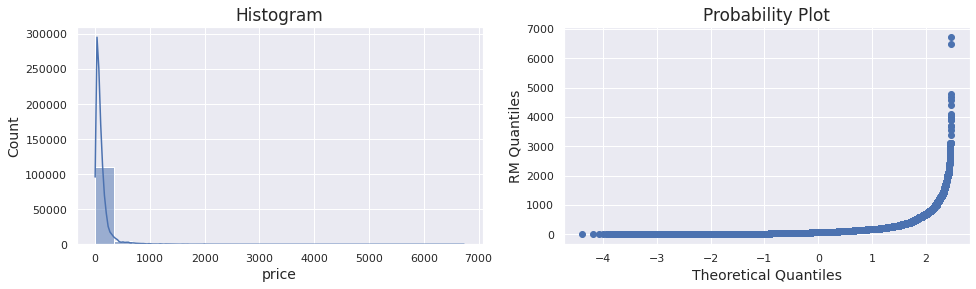

**2. Plot for freight_value**

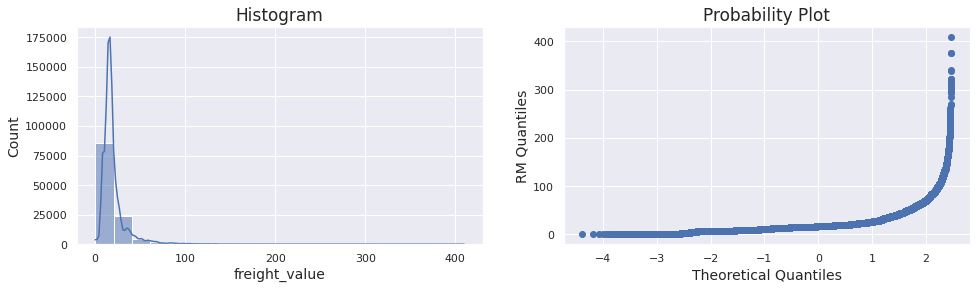

**3. Plot for order_item_id**

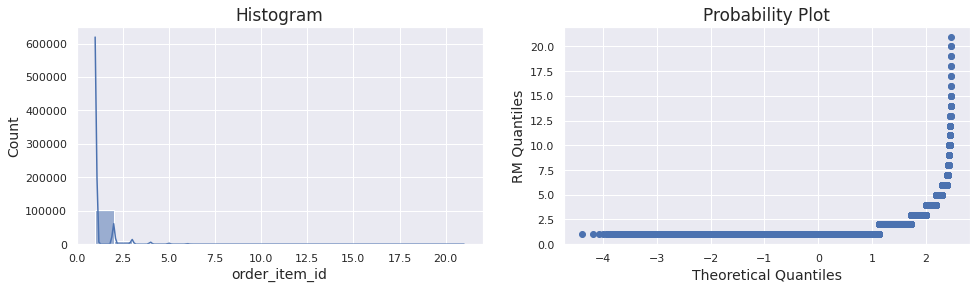

**4. Plot for product_weight_g**

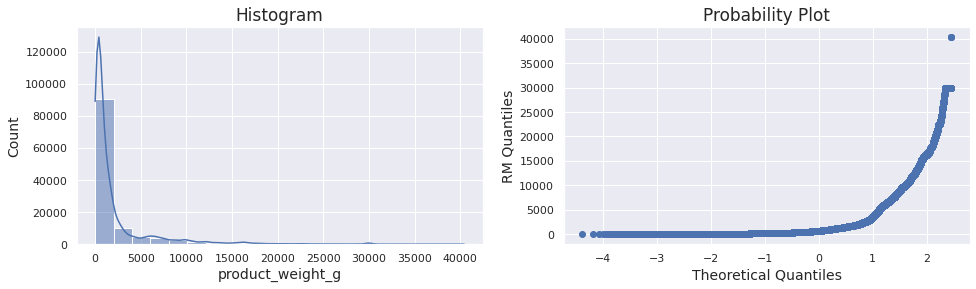

**5. Plot for product_length_cm**

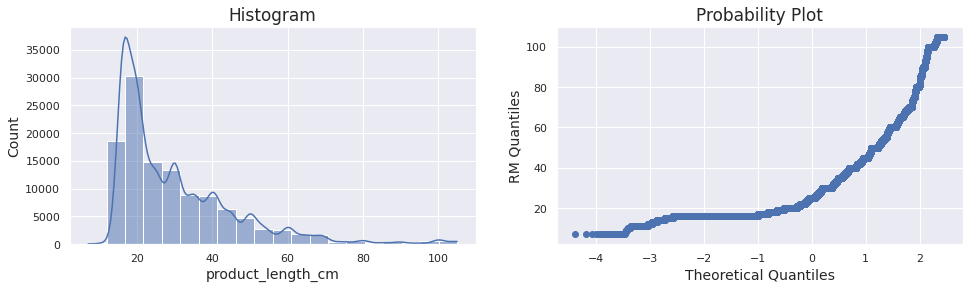

**6. Plot for product_height_cm**

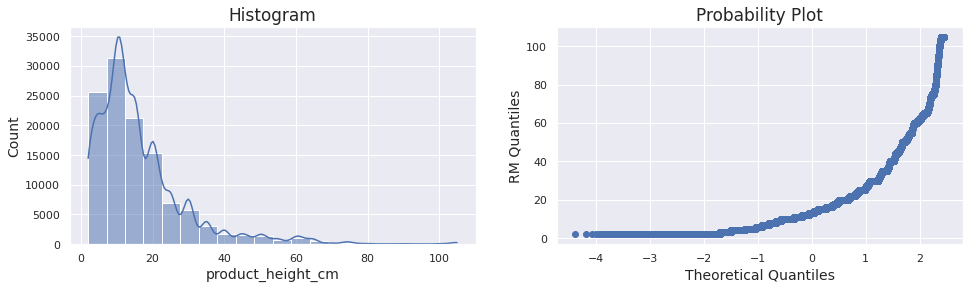

**7. Plot for product_width_cm**

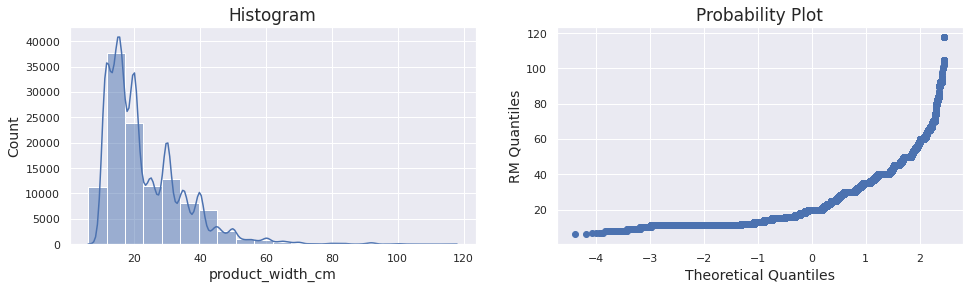

**8. Plot for product_name_lenght**

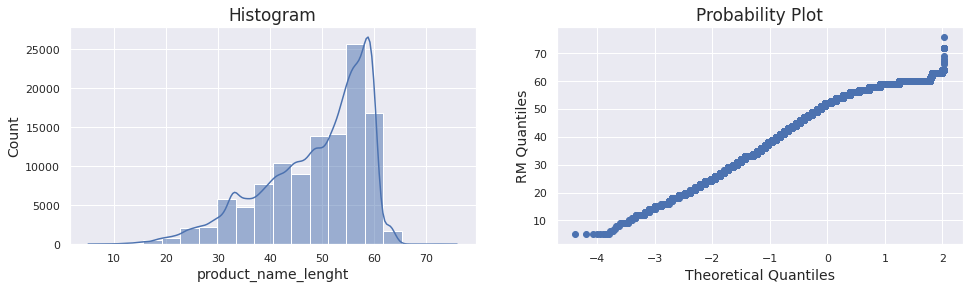

**9. Plot for product_description_lenght**

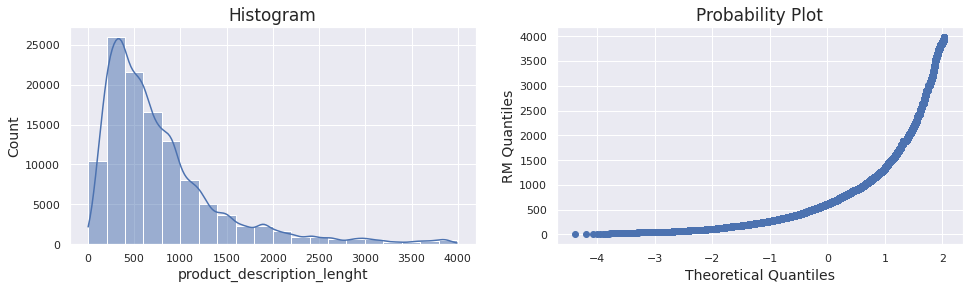

**10. Plot for product_photos_qty**

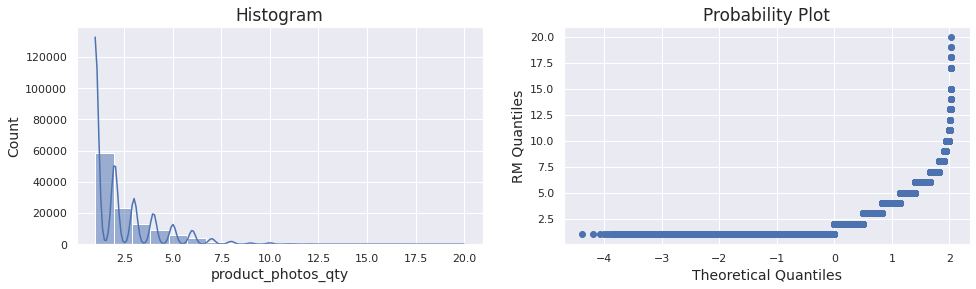

**11. Plot for payment_sequential**

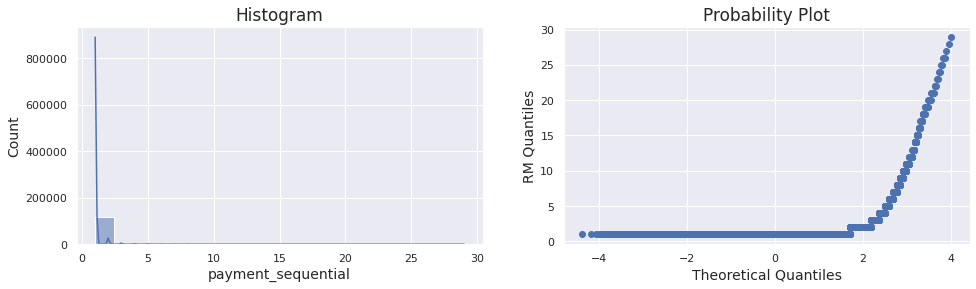

**12. Plot for payment_installments**

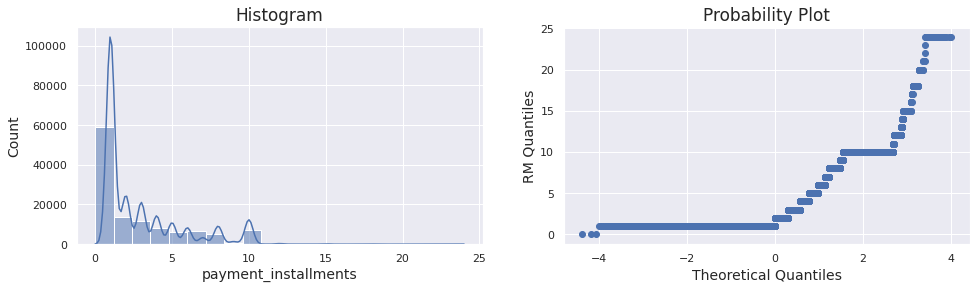

**13. Plot for payment_value**

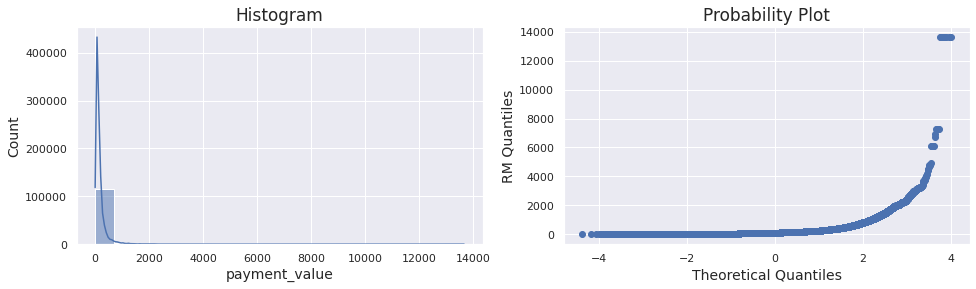

**14. Plot for review_score**

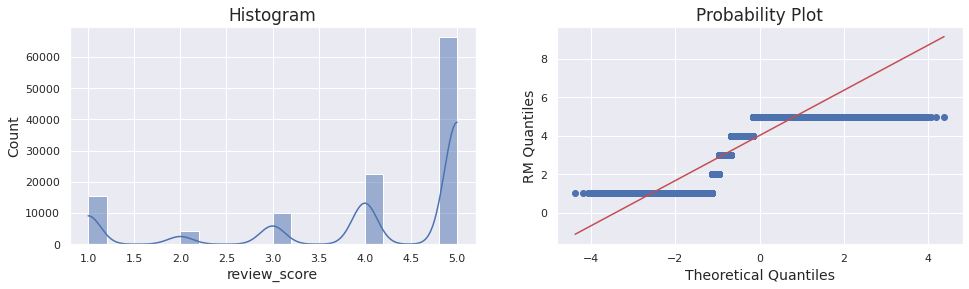

In [33]:
eda.numerical_plots(orders, cont_columns, normality_check = True)

**<u>Basic Info :</u>**

Total Number of observations :  118146



**<u>Cardinality of the variable :</u>**

Number of Distinct Categories (Cardinality):  5
Distinct Values :  [4 5 1 3 2]



**<u>Missing Values :</u>**

  Number : 0
  Percentage : 0.0 %


**<u>Category Plots :</u>**

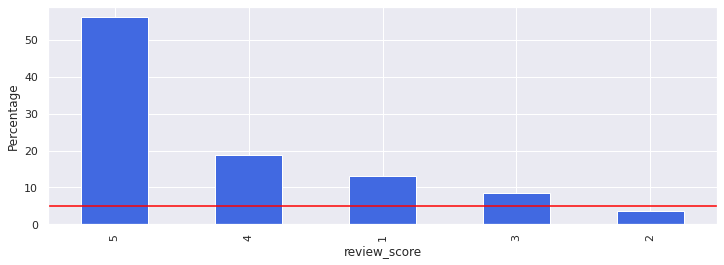

**<u>Category plot by including missing (if any) and Rare labels**

Categories less than 5 value are clubbed in Rare label


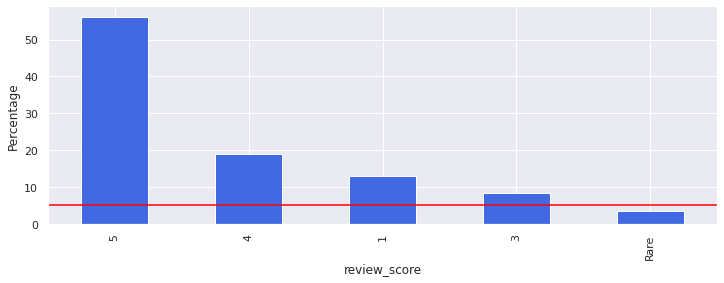

In [34]:
eda.categorical_variable_detail(orders, variable = "review_score")

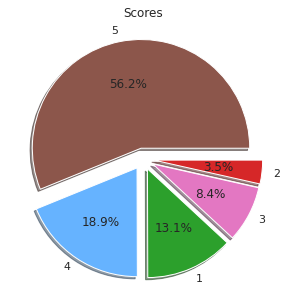

In [35]:
fig, ax = plt.subplots(figsize = (10, 5))
orders["review_score"].value_counts().plot.pie(explode = [0.1, 0.1, 0.1, 0.1, 0.1], autopct = "%1.1f%%", colors = ['#8c564b','#66b3ff', '#2ca02c', '#e377c2', '#d62728'], shadow = True)
ax.set_title("Scores")
ax.set_ylabel('')
plt.show()

In [36]:
items_reviews = pd.merge(order_reviews, order_items, how='left', on='order_id')
review_qty = items_reviews.groupby('review_score').size()
review_value = items_reviews.groupby('review_score')['price'].mean()

In [37]:
trace0 = go.Bar(
    x=review_qty.index,
    y=review_qty.values,
    name='Number of orders',
    marker=dict(color='rgb(49,130,189)')
)
trace1 = go.Bar(
    x=review_value.index,
    y=review_value.values,
    name='Product mean value',
    marker=dict(color='rgb(204,204,204)')
)
fig = make_subplots(rows=1, cols=2, print_grid=False)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(height=400, width=800, title='Review Score')
fig['layout']['xaxis1'].update(title='review score', domain=[0, 0.40], tickmode = 'linear')
fig['layout']['xaxis2'].update(title='review score', domain=[0.6, 1], tickmode = 'linear')
iplot(fig);

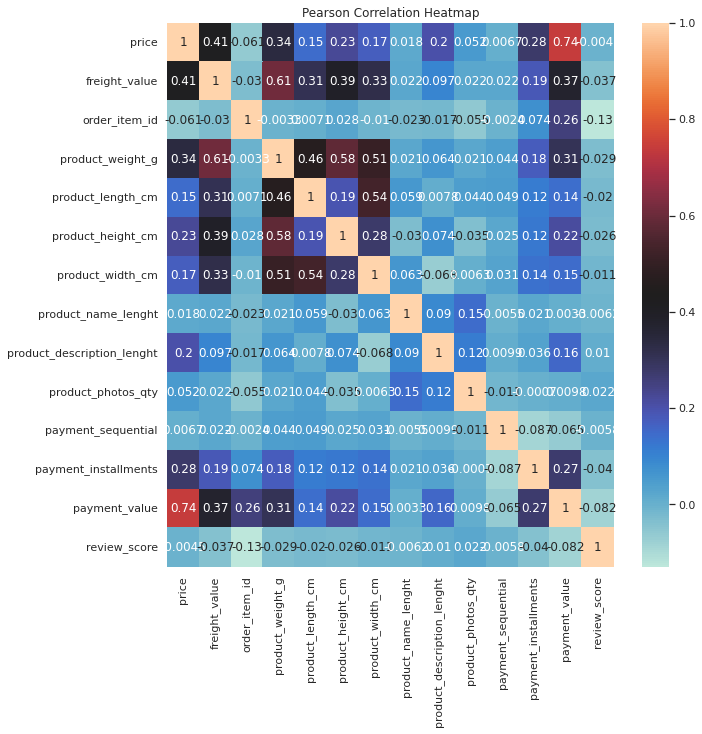

In [38]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.title("Pearson Correlation Heatmap")
sns.heatmap(orders.corr(method = 'pearson'), annot = True, cmap = 'icefire')
plt.show()

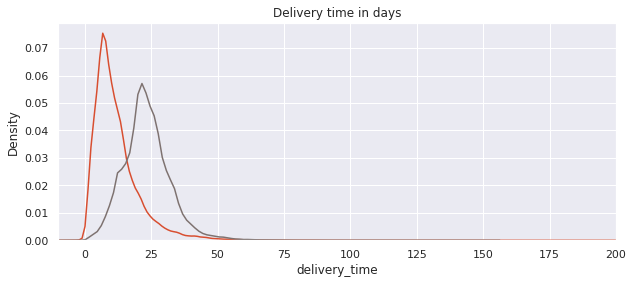

In [39]:
orders_df['order_purchase_timestamp'] = pd.to_datetime(orders_df['order_purchase_timestamp'])
orders_df['order_approved_at'] = pd.to_datetime(orders_df['order_approved_at'])
orders_df['order_estimated_delivery_date'] = pd.to_datetime(orders_df['order_estimated_delivery_date'])
orders_df['order_delivered_customer_date'] = pd.to_datetime(orders_df['order_delivered_customer_date'])
orders_df['delivery_time'] = (orders_df['order_delivered_customer_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
orders_df['estimated_delivery_time'] = (orders_df['order_estimated_delivery_date'] - orders_df['order_approved_at']).dt.total_seconds() / 86400
plt.figure(figsize=(10,4))
plt.title("Delivery time in days")
plt.xlim(-10, 200)

ax1 = sns.kdeplot(orders_df['delivery_time'].dropna(), color="#D84E30", label='Delivery time')
ax2 = sns.kdeplot(orders_df['estimated_delivery_time'].dropna(), color="#7E7270", label='Estimated delivery time')

##4. Feature Engineering

In [40]:
orders.head(10)

,customer_id,order_status,price,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_state,...,product_name_lenght,product_description_lenght,product_photos_qty,payment_sequential,payment_type,payment_installments,payment_value,review_creation_date,review_answer_timestamp,review_score
0,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,SP,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
1,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,SP,...,42.0,858.0,1.0,1.0,credit_card,8.0,397.26,2018-01-18,2018-01-18,4
2,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,SP,...,47.0,493.0,1.0,1.0,credit_card,1.0,88.09,2018-03-11,2018-03-11,5
3,e226dfed6544df5b7b87a48208690feb,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,BA,...,59.0,1893.0,1.0,1.0,credit_card,1.0,194.12,2018-02-18,2018-02-18,5
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,SC,...,33.0,2188.0,2.0,1.0,credit_card,1.0,222.84,2017-04-21,2017-04-21,5
5,5986b333ca0d44534a156a52a8e33a83,delivered,1199.00,2018-02-10,2018-02-10,2018-03-09,2018-02-28,134.25,1.0,SC,...,48.0,562.0,5.0,1.0,credit_card,10.0,1333.25,2018-03-02,2018-03-02,5
6,eecafc3ff695f031bfe354a9fff9d437,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,1.0,SP,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
7,eecafc3ff695f031bfe354a9fff9d437,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,2.0,SP,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
8,eecafc3ff695f031bfe354a9fff9d437,delivered,119.00,2018-04-06,2018-04-09,2018-05-03,2018-04-12,4.40,3.0,SP,...,30.0,568.0,1.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1
9,eecafc3ff695f031bfe354a9fff9d437,delivered,99.90,2018-04-06,2018-04-09,2018-05-03,2018-04-12,13.20,4.0,SP,...,57.0,246.0,2.0,1.0,credit_card,1.0,462.70,2018-04-16,2018-04-16,1


In [41]:
orders.shape

(118146, 25)

In [42]:
cat_columns

['customer_id',
 'order_status',
 'order_purchase_timestamp',
 'order_approved_at',
 'order_estimated_delivery_date',
 'order_delivered_customer_date',
 'customer_state',
 'product_category_name_english',
 'payment_type',
 'review_creation_date',
 'review_answer_timestamp']

In [43]:
cont_columns

['price',
 'freight_value',
 'order_item_id',
 'product_weight_g',
 'product_length_cm',
 'product_height_cm',
 'product_width_cm',
 'product_name_lenght',
 'product_description_lenght',
 'product_photos_qty',
 'payment_sequential',
 'payment_installments',
 'payment_value',
 'review_score']

In [44]:
skew_data = orders.skew(axis = 0, skipna = True)
skew_data

<ipython-input-44-f22a5d68bcc6>:1: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



price                          7.652406
freight_value                  5.552176
order_item_id                  7.181680
product_weight_g               3.582198
product_length_cm              1.745291
product_height_cm              2.239916
product_width_cm               1.705233
product_name_lenght           -0.905520
product_description_lenght     2.011468
product_photos_qty             1.910438
payment_sequential            15.732593
payment_installments           1.622332
payment_value                 14.127975
review_score                  -1.245767
dtype: float64

In [45]:
orders['delivery_time'] = orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']

In [46]:
def delivery_time_days(x): #regarding delivery time
    if x >= 7 :
        return 'Slow'
    elif 4<=x<=6:
        return 'Medium'
    else:
        return 'Fast'
    
orders['delivery_time_class'] = orders['delivery_time'].dt.days.apply(lambda x: delivery_time_days(x))

In [47]:
orders['delivery_time_class']

0         Medium
1         Medium
2           Slow
3           Slow
4           Slow
           ...  
118141      Slow
118142    Medium
118143      Fast
118144      Slow
118145      Fast
Name: delivery_time_class, Length: 118146, dtype: object

In [48]:
orders['review_upload_time'] = orders['review_answer_timestamp'] - orders['review_creation_date']

In [49]:
def respone_by_seller(x): #regarding seller response time
    if x > 3 :
        return 'Slow'
    elif x == 0 :
        return 'On Time'
    else:
        return 'Fast'
    
orders['seller_response'] = orders['review_upload_time'].dt.days.apply(lambda x: respone_by_seller(x))

In [50]:
orders['seller_response']

0         On Time
1         On Time
2         On Time
3         On Time
4         On Time
           ...   
118141    On Time
118142    On Time
118143    On Time
118144    On Time
118145    On Time
Name: seller_response, Length: 118146, dtype: object

In [51]:
def payment_vals(x): #regarding price of the product
    if x >= 700.00:
        return 'Expensive'
    elif 200.00<=x<=699.99:
        return 'Medium'
    else:
        return 'Cheap'
    
orders['payment_value_class'] = orders.payment_value.apply(lambda x: payment_vals(x))

In [52]:
orders['payment_value_class']

0         Medium
1         Medium
2          Cheap
3          Cheap
4         Medium
           ...  
118141    Medium
118142    Medium
118143    Medium
118144     Cheap
118145     Cheap
Name: payment_value_class, Length: 118146, dtype: object

In [53]:
def customer_debentures(x): #regarding installments due
    if x == 1:
        return False
    else:
        return True

orders['customer_debt'] = orders.payment_installments.apply(lambda x: customer_debentures(x)) 

In [54]:
orders['customer_debt']

0          True
1          True
2         False
3         False
4         False
          ...  
118141     True
118142    False
118143     True
118144    False
118145    False
Name: customer_debt, Length: 118146, dtype: bool

In [55]:
def customer_cash_based_payment(x): #regarding customer payment method
    if x == ('boleto'):
        return True
    elif x == ('debit_card'):
        return True
    else:
        return False
    
orders['cash_customer_payment'] = orders.payment_type.apply(lambda x: customer_cash_based_payment(x)) 

In [56]:
orders['cash_customer_payment'] 

0         False
1         False
2         False
3         False
4         False
          ...  
118141    False
118142    False
118143    False
118144    False
118145     True
Name: cash_customer_payment, Length: 118146, dtype: bool

In [57]:
def product_weight(x): #regarding product weight
    if x > 3700:
        return 'Heavy'
    elif 1700<=x<=3700:
        return 'Medium'
    else:
        return 'Light'
    
orders['product_width_class'] = orders.product_weight_g.apply(lambda x: product_weight(x))

In [58]:
orders['product_width_class']

0          Light
1          Light
2          Light
3          Heavy
4          Heavy
           ...  
118141     Heavy
118142    Medium
118143     Heavy
118144     Light
118145     Light
Name: product_width_class, Length: 118146, dtype: object

In [59]:
orders

,customer_id,order_status,price,order_purchase_timestamp,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_state,...,review_answer_timestamp,review_score,delivery_time,delivery_time_class,review_upload_time,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,SP,...,2018-01-18,4,6 days,Medium,0 days,On Time,Medium,True,False,Light
1,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,SP,...,2018-01-18,4,6 days,Medium,0 days,On Time,Medium,True,False,Light
2,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,SP,...,2018-03-11,5,9 days,Slow,0 days,On Time,Cheap,False,False,Light
3,e226dfed6544df5b7b87a48208690feb,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,BA,...,2018-02-18,5,13 days,Slow,0 days,On Time,Cheap,False,False,Heavy
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,SC,...,2017-04-21,5,11 days,Slow,0 days,On Time,Medium,False,False,Heavy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,226.77,2018-06-27,2018-06-28,2018-07-20,2018-07-06,61.20,1.0,GO,...,2018-07-14,5,9 days,Slow,0 days,On Time,Medium,True,False,Heavy
118142,d0d7086dea6fcf42b9b690b9f3745c58,delivered,199.99,2017-12-03,2017-12-03,2017-12-20,2017-12-08,9.77,1.0,RJ,...,2017-12-11,5,5 days,Medium,0 days,On Time,Medium,False,False,Medium
118143,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,215.97,2018-03-18,2018-03-18,2018-04-06,2018-03-21,15.59,1.0,MG,...,2018-03-23,5,3 days,Fast,0 days,On Time,Medium,True,False,Heavy
118144,3aa00401736823c73e9fe8683328fa6b,delivered,50.95,2018-06-22,2018-06-22,2018-07-16,2018-06-30,15.46,1.0,MG,...,2018-07-02,4,8 days,Slow,0 days,On Time,Cheap,False,False,Light


In [60]:
orders = orders.rename(columns = {'order_purchase_timestamp' : 'last_transaction'})

In [61]:
def churn(x):
    try:
        tgl_last_transaction = pd.to_datetime(x)
        timedelta = dt.datetime(2018, 10, 1) - tgl_last_transaction
        time = timedelta.days
        if time > 365:
            return True
        else:
            return False
    except:
        return True
    
orders['churn'] = orders.last_transaction.apply(lambda x: churn(x))


In [62]:
orders['churn'].value_counts()

False    85005
True     33141
Name: churn, dtype: int64

**<u>Basic Info :</u>**

Total Number of observations :  118146



**<u>Cardinality of the variable :</u>**

Number of Distinct Categories (Cardinality):  2
Distinct Values :  [False  True]



**<u>Missing Values :</u>**

  Number : 0
  Percentage : 0.0 %


**<u>Category Plots :</u>**

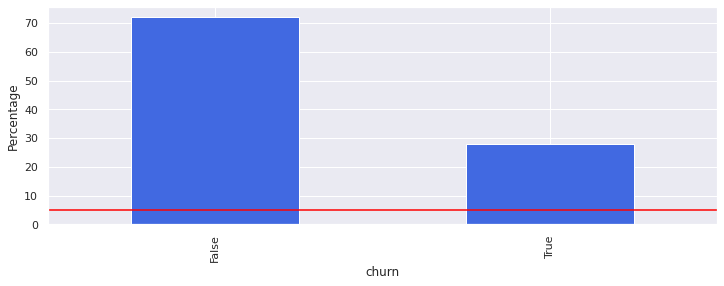

**<u>Category plot by including missing (if any) and Rare labels**

Categories less than 5 value are clubbed in Rare label


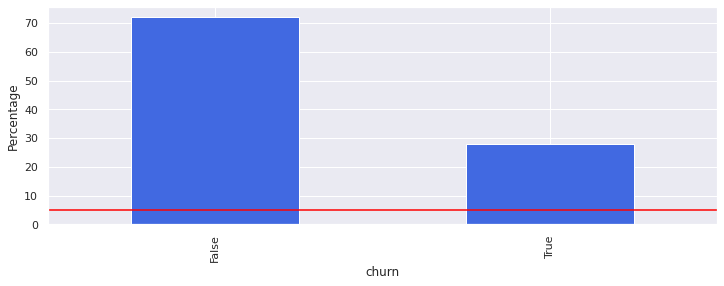

In [63]:
eda.categorical_variable_detail(orders, variable = "churn")

In [64]:
orders

,customer_id,order_status,price,last_transaction,order_approved_at,order_estimated_delivery_date,order_delivered_customer_date,freight_value,order_item_id,customer_state,...,review_score,delivery_time,delivery_time_class,review_upload_time,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class,churn
0,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,1.0,SP,...,4,6 days,Medium,0 days,On Time,Medium,True,False,Light,False
1,41dcb106f807e993532d446263290104,delivered,185.00,2018-01-11,2018-01-11,2018-02-02,2018-01-17,13.63,2.0,SP,...,4,6 days,Medium,0 days,On Time,Medium,True,False,Light,False
2,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,79.79,2018-02-28,2018-02-28,2018-03-14,2018-03-09,8.30,1.0,SP,...,5,9 days,Slow,0 days,On Time,Cheap,False,False,Light,False
3,e226dfed6544df5b7b87a48208690feb,delivered,149.00,2018-02-03,2018-02-03,2018-03-09,2018-02-16,45.12,1.0,BA,...,5,13 days,Slow,0 days,On Time,Cheap,False,False,Heavy,False
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,179.99,2017-04-09,2017-04-09,2017-05-10,2017-04-20,42.85,1.0,SC,...,5,11 days,Slow,0 days,On Time,Medium,False,False,Heavy,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118141,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,226.77,2018-06-27,2018-06-28,2018-07-20,2018-07-06,61.20,1.0,GO,...,5,9 days,Slow,0 days,On Time,Medium,True,False,Heavy,False
118142,d0d7086dea6fcf42b9b690b9f3745c58,delivered,199.99,2017-12-03,2017-12-03,2017-12-20,2017-12-08,9.77,1.0,RJ,...,5,5 days,Medium,0 days,On Time,Medium,False,False,Medium,False
118143,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,215.97,2018-03-18,2018-03-18,2018-04-06,2018-03-21,15.59,1.0,MG,...,5,3 days,Fast,0 days,On Time,Medium,True,False,Heavy,False
118144,3aa00401736823c73e9fe8683328fa6b,delivered,50.95,2018-06-22,2018-06-22,2018-07-16,2018-06-30,15.46,1.0,MG,...,4,8 days,Slow,0 days,On Time,Cheap,False,False,Light,False


In [65]:
orders.columns

Index(['customer_id', 'order_status', 'price', 'last_transaction',
       'order_approved_at', 'order_estimated_delivery_date',
       'order_delivered_customer_date', 'freight_value', 'order_item_id',
       'customer_state', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_creation_date', 'review_answer_timestamp',
       'review_score', 'delivery_time', 'delivery_time_class',
       'review_upload_time', 'seller_response', 'payment_value_class',
       'customer_debt', 'cash_customer_payment', 'product_width_class',
       'churn'],
      dtype='object')

In [66]:
orders.drop(columns=['price', 'last_transaction',
       'order_approved_at', 'order_estimated_delivery_date',
       'order_delivered_customer_date', 'freight_value', 
       'customer_state', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'review_creation_date', 'review_answer_timestamp', 'review_upload_time', 'delivery_time'], inplace = True)

In [67]:
orders

,customer_id,order_status,order_item_id,product_photos_qty,review_score,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class,churn
0,41dcb106f807e993532d446263290104,delivered,1.0,1.0,4,Medium,On Time,Medium,True,False,Light,False
1,41dcb106f807e993532d446263290104,delivered,2.0,1.0,4,Medium,On Time,Medium,True,False,Light,False
2,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,1.0,1.0,5,Slow,On Time,Cheap,False,False,Light,False
3,e226dfed6544df5b7b87a48208690feb,delivered,1.0,1.0,5,Slow,On Time,Cheap,False,False,Heavy,False
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,1.0,2.0,5,Slow,On Time,Medium,False,False,Heavy,True
...,...,...,...,...,...,...,...,...,...,...,...,...
118141,d8c466a3e7c4cda36cd4ae7d577f44f4,delivered,1.0,1.0,5,Slow,On Time,Medium,True,False,Heavy,False
118142,d0d7086dea6fcf42b9b690b9f3745c58,delivered,1.0,1.0,5,Medium,On Time,Medium,False,False,Medium,False
118143,fcc7b1caafe3b77fd587bab964c4d1fb,delivered,1.0,3.0,5,Fast,On Time,Medium,True,False,Heavy,False
118144,3aa00401736823c73e9fe8683328fa6b,delivered,1.0,5.0,4,Slow,On Time,Cheap,False,False,Light,False


In [68]:
#log_transform = np.log(orders[cont_columns] + 1)
#log_transform

In [69]:
#orders = orders.drop(columns = cont_columns, axis = 1)

In [70]:
#orders.head(10)

In [71]:
#orders = pd.concat([orders, log_transform], axis = 1)

In [72]:
#orders.head(10)

In [73]:
#orders.shape

In [74]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118146 entries, 0 to 118145
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   customer_id            118146 non-null  object 
 1   order_status           118146 non-null  object 
 2   order_item_id          117332 non-null  float64
 3   product_photos_qty     115637 non-null  float64
 4   review_score           118146 non-null  int64  
 5   delivery_time_class    118146 non-null  object 
 6   seller_response        118146 non-null  object 
 7   payment_value_class    118146 non-null  object 
 8   customer_debt          118146 non-null  bool   
 9   cash_customer_payment  118146 non-null  bool   
 10  product_width_class    118146 non-null  object 
 11  churn                  118146 non-null  bool   
dtypes: bool(3), float64(2), int64(1), object(6)
memory usage: 13.4+ MB


In [75]:
for c in orders.select_dtypes(include = ([np.number])).columns.values:
  orders[c].fillna(orders[c].median(), inplace=True)

for c in orders.select_dtypes(include = (['object'])).columns.values:
  orders[c].fillna(orders[c].mode().values[0], inplace=True)  

In [76]:
elpenv = EllipticEnvelope(contamination=0.025, random_state=1)
  # Returns 1 of inliers, -1 for outliers
pred = elpenv.fit_predict(orders[list(orders.select_dtypes(include=[np.number]).columns.values)])

anom_index = np.where(pred==-1)
rem = orders.loc[anom_index]

rem

,customer_id,order_status,order_item_id,product_photos_qty,review_score,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class,churn
8,eecafc3ff695f031bfe354a9fff9d437,delivered,3.0,1.0,1,Medium,On Time,Medium,False,False,Light,False
9,eecafc3ff695f031bfe354a9fff9d437,delivered,4.0,2.0,1,Medium,On Time,Medium,False,False,Light,False
18,b1af08103e1e17838522e5b9fbe2ed11,delivered,4.0,1.0,5,Slow,On Time,Medium,False,True,Light,False
19,b1af08103e1e17838522e5b9fbe2ed11,delivered,5.0,1.0,5,Slow,On Time,Medium,False,True,Light,False
57,c17d38e818f10c91ebcd036bc835a648,delivered,3.0,1.0,1,Slow,On Time,Medium,True,False,Light,True
...,...,...,...,...,...,...,...,...,...,...,...,...
117934,65095fecef8545e033e0b83b85e146fa,delivered,3.0,1.0,1,Slow,On Time,Cheap,True,False,Light,False
118048,36318088e4bc5369085a4550491f9d60,delivered,3.0,2.0,1,Slow,On Time,Medium,True,False,Medium,False
118114,424bb0b58d2a1f8f1a185d44a8116aae,delivered,4.0,2.0,3,Slow,On Time,Medium,False,False,Light,False
118115,424bb0b58d2a1f8f1a185d44a8116aae,delivered,5.0,2.0,3,Slow,On Time,Medium,False,False,Light,False


In [77]:
orders.drop(index = rem.index, axis = 0, inplace = True)

In [78]:
orders.shape

(115155, 12)

In [79]:
X = orders.drop('churn', axis = 1)
y = orders['churn']

In [80]:
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [81]:
X.shape, y.shape

((115155, 11), (115155,))

In [82]:
X.head(10)

,customer_id,order_status,order_item_id,product_photos_qty,review_score,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,41dcb106f807e993532d446263290104,delivered,1.0,1.0,4,Medium,On Time,Medium,True,False,Light
1,41dcb106f807e993532d446263290104,delivered,2.0,1.0,4,Medium,On Time,Medium,True,False,Light
2,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,1.0,1.0,5,Slow,On Time,Cheap,False,False,Light
3,e226dfed6544df5b7b87a48208690feb,delivered,1.0,1.0,5,Slow,On Time,Cheap,False,False,Heavy
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,1.0,2.0,5,Slow,On Time,Medium,False,False,Heavy
5,5986b333ca0d44534a156a52a8e33a83,delivered,1.0,5.0,5,Slow,On Time,Expensive,True,False,Heavy
6,eecafc3ff695f031bfe354a9fff9d437,delivered,1.0,2.0,1,Medium,On Time,Medium,False,False,Light
7,eecafc3ff695f031bfe354a9fff9d437,delivered,2.0,2.0,1,Medium,On Time,Medium,False,False,Light
10,840be0730010e9580efd289bc9f37706,delivered,1.0,1.0,5,Slow,On Time,Cheap,True,False,Light
11,98f485515e575607a8003b17e91990bd,delivered,1.0,9.0,5,Medium,On Time,Cheap,True,False,Heavy


In [83]:
y.head(10)

0     False
1     False
2     False
3     False
4      True
5     False
6     False
7     False
10     True
11    False
Name: churn, dtype: bool

In [84]:
X.dtypes

customer_id               object
order_status              object
order_item_id            float64
product_photos_qty       float64
review_score               int64
delivery_time_class       object
seller_response           object
payment_value_class       object
customer_debt               bool
cash_customer_payment       bool
product_width_class       object
dtype: object

In [85]:
def pipe(X):
  X_num_col = X.select_dtypes(include = ([np.number])).columns.values
  X_num_cat = X.select_dtypes(include = (['object'])).columns.values

  cat_cols = X_num_cat
  cont_cols = X_num_col 
  
  full_pipe = ColumnTransformer(transformers = [('ord_enc', OrdinalEncoder(), cat_cols), ('std_scl', StandardScaler(), cont_cols)],
                                remainder = 'passthrough')
  
  X_pipe = full_pipe.fit_transform(X)

  return X_pipe

In [86]:
X_feat = pipe(X)
X_feat

array([[ 2.52470000e+04,  3.00000000e+00,  1.00000000e+00, ...,
        -3.43443880e-02,  1.00000000e+00,  0.00000000e+00],
       [ 2.52470000e+04,  3.00000000e+00,  1.00000000e+00, ...,
        -3.43443880e-02,  1.00000000e+00,  0.00000000e+00],
       [ 5.29640000e+04,  3.00000000e+00,  2.00000000e+00, ...,
         6.92664436e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.70940000e+04,  3.00000000e+00,  0.00000000e+00, ...,
         6.92664436e-01,  1.00000000e+00,  0.00000000e+00],
       [ 2.25600000e+04,  3.00000000e+00,  2.00000000e+00, ...,
        -3.43443880e-02,  0.00000000e+00,  0.00000000e+00],
       [ 9.49670000e+04,  3.00000000e+00,  0.00000000e+00, ...,
        -2.21537086e+00,  0.00000000e+00,  1.00000000e+00]])

In [87]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_feat, i) for i in range(X_feat.shape[1])]
vif["Features"] = X.columns
vif

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning:

invalid value encountered in double_scalars



,vif,Features
0,3.838760,customer_id
1,10.760668,order_status
2,5.889727,order_item_id
3,NaN,product_photos_qty
4,1.395827,review_score
5,4.389816,delivery_time_class
6,1.040058,seller_response
7,1.005295,payment_value_class
8,1.018053,customer_debt
9,2.809454,cash_customer_payment


In [88]:
vif_filtered = vif[vif['vif']<10]
vif_filtered

,vif,Features
0,3.838760,customer_id
2,5.889727,order_item_id
4,1.395827,review_score
5,4.389816,delivery_time_class
6,1.040058,seller_response
7,1.005295,payment_value_class
8,1.018053,customer_debt
9,2.809454,cash_customer_payment
10,1.727953,product_width_class


In [89]:
cols = list(vif_filtered['Features'].unique())
X_filtered = X[cols]
X_filtered

,customer_id,order_item_id,review_score,delivery_time_class,seller_response,payment_value_class,customer_debt,cash_customer_payment,product_width_class
0,41dcb106f807e993532d446263290104,1.0,4,Medium,On Time,Medium,True,False,Light
1,41dcb106f807e993532d446263290104,2.0,4,Medium,On Time,Medium,True,False,Light
2,8a2e7ef9053dea531e4dc76bd6d853e6,1.0,5,Slow,On Time,Cheap,False,False,Light
3,e226dfed6544df5b7b87a48208690feb,1.0,5,Slow,On Time,Cheap,False,False,Heavy
4,de6dff97e5f1ba84a3cd9a3bc97df5f6,1.0,5,Slow,On Time,Medium,False,False,Heavy
...,...,...,...,...,...,...,...,...,...
118141,d8c466a3e7c4cda36cd4ae7d577f44f4,1.0,5,Slow,On Time,Medium,True,False,Heavy
118142,d0d7086dea6fcf42b9b690b9f3745c58,1.0,5,Medium,On Time,Medium,False,False,Medium
118143,fcc7b1caafe3b77fd587bab964c4d1fb,1.0,5,Fast,On Time,Medium,True,False,Heavy
118144,3aa00401736823c73e9fe8683328fa6b,1.0,4,Slow,On Time,Cheap,False,False,Light


In [90]:
X_cont = list(X_filtered.select_dtypes(include=[np.number]).columns.values)
X_cat = list(X_filtered.select_dtypes(include=['object']).columns.values)

In [91]:
X_featured = pipe(X_filtered)
X_featured

array([[ 2.52470000e+04,  1.00000000e+00,  0.00000000e+00, ...,
        -3.43443880e-02,  1.00000000e+00,  0.00000000e+00],
       [ 2.52470000e+04,  1.00000000e+00,  0.00000000e+00, ...,
        -3.43443880e-02,  1.00000000e+00,  0.00000000e+00],
       [ 5.29640000e+04,  2.00000000e+00,  0.00000000e+00, ...,
         6.92664436e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 9.70940000e+04,  0.00000000e+00,  0.00000000e+00, ...,
         6.92664436e-01,  1.00000000e+00,  0.00000000e+00],
       [ 2.25600000e+04,  2.00000000e+00,  0.00000000e+00, ...,
        -3.43443880e-02,  0.00000000e+00,  0.00000000e+00],
       [ 9.49670000e+04,  0.00000000e+00,  0.00000000e+00, ...,
        -2.21537086e+00,  0.00000000e+00,  1.00000000e+00]])

In [92]:
X_featured.shape, y.shape

((115155, 9), (115155,))

In [93]:
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_featured, y)

Overall dataset values have been decreased.
Original size:
 False    82802
True     32353
Name: churn, dtype: int64
New size:
 False    82802
True     82802
Name: churn, dtype: int64


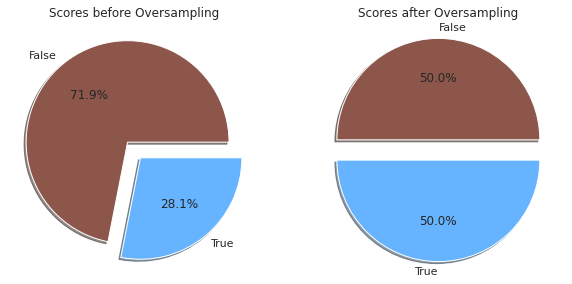

In [94]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10), squeeze = False)
ax = ax.ravel()
y.value_counts().plot.pie(explode = [0.1, 0.1], autopct = "%1.1f%%", ax = ax[0], colors = ['#8c564b','#66b3ff'], shadow = True)
ax[0].set_title("Scores before Oversampling")
ax[0].set_ylabel('')
y_sm.value_counts().plot.pie(explode = [0.1, 0.1], autopct = "%1.1f%%", ax = ax[1], colors = ['#8c564b','#66b3ff'], shadow = True)
ax[1].set_title("Scores after Oversampling")
ax[1].set_ylabel('')

print("Overall dataset values have been decreased.")
print("Original size:\n", y.value_counts())
print("New size:\n", y_sm.value_counts())
plt.show()

In [95]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.33, random_state=42)
for train_index, test_index in split.split(X_sm, y_sm):
  X_train, X_test = X_sm[train_index], X_sm[test_index]
  y_train, y_test = y_sm[train_index], y_sm[test_index]

In [96]:
X_train.shape, y_train.shape

((110954, 9), (110954,))

In [97]:
X_test.shape, y_test.shape

((54650, 9), (54650,))

##5. Data Modelling



In [98]:
def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize = (10,8))
    sns.barplot(x = fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE') 
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


### K-Neighbours Classifier



In [99]:
model_knn = KNeighborsClassifier(n_jobs = -1)
model_knn.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1)

In [100]:
train_acc_knn = model_knn.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_knn*100))

The Accuracy for Training Set is 78.0710925248301


In [101]:
y_pred_knn = model_knn.predict(X_test)
test_acc_knn = accuracy_score(y_test, y_pred_knn) 
print("The Accuracy for Test Set is {}".format(test_acc_knn*100))

The Accuracy for Test Set is 66.19030192131747


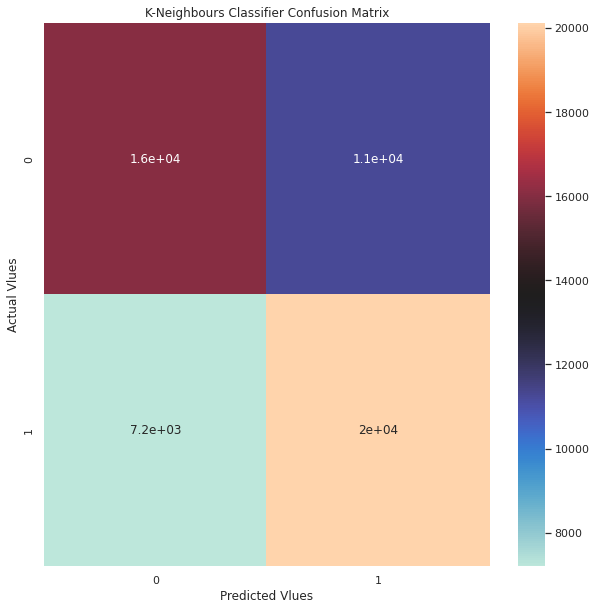

In [102]:
plt.figure(figsize=(10,10))
plt.title("K-Neighbours Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_knn), annot = True, cmap ='icefire')
plt.ylabel("Actual Vlues")
plt.xlabel("Predicted Vlues")
plt.show()

####Hyperparamter Tuning

In [103]:
def objective(trial):

    leaf_size =  trial.suggest_int('leaf_size', 1, 50)
    n_neighbors = trial.suggest_int('n_neighbors', 1, 100)
    p = trial.suggest_int('p', 1, 2)

    knc = KNeighborsClassifier(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p)

    score = cross_val_score(knc, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-01-14 05:55:34,753] A new study created in memory with name: no-name-e363de50-f30d-4404-95b3-5ad81fd70db6
[I 2023-01-14 05:55:41,280] Trial 0 finished with value: 0.5612776170438348 and parameters: {'leaf_size': 37, 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.5612776170438348.
[I 2023-01-14 05:55:45,621] Trial 1 finished with value: 0.6289272650697033 and parameters: {'leaf_size': 31, 'n_neighbors': 9, 'p': 1}. Best is trial 1 with value: 0.6289272650697033.
[I 2023-01-14 05:55:51,355] Trial 2 finished with value: 0.5408187396938485 and parameters: {'leaf_size': 9, 'n_neighbors': 71, 'p': 2}. Best is trial 1 with value: 0.6289272650697033.
[I 2023-01-14 05:55:57,464] Trial 3 finished with value: 0.5364655654849864 and parameters: {'leaf_size': 19, 'n_neighbors': 89, 'p': 1}. Best is trial 1 with value: 0.6289272650697033.
[I 2023-01-14 05:56:03,126] Trial 4 finished with value: 0.5596643248162045 and parameters: {'leaf_size': 14, 'n_neighbors': 31, 'p': 2}. Best i

In [104]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.6940353511239399
Best hyperparameters: {'leaf_size': 22, 'n_neighbors': 2, 'p': 1}


In [105]:
optuna.visualization.plot_optimization_history(study)

In [106]:
optuna.visualization.plot_slice(study)

In [107]:
best_params = trial.params
best_params

{'leaf_size': 22, 'n_neighbors': 2, 'p': 1}

In [108]:
model_knn_hp = KNeighborsClassifier(**best_params, n_jobs = -1)
model_knn_hp.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=22, n_jobs=-1, n_neighbors=2, p=1)

In [109]:
y_pred_knn_hp = model_knn_hp.predict(X_test)

In [110]:
train_acc_knn_hp = model_knn_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_knn_hp*100))

The Accuracy for Training Set is 91.08369234097013


In [111]:
test_acc_knn_hp = accuracy_score(y_test, y_pred_knn_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_knn_hp*100))

The Accuracy for Test Set is 71.69807868252516


In [112]:
print(classification_report(y_test, y_pred_knn_hp))

              precision    recall  f1-score   support

       False       0.69      0.80      0.74     27325
        True       0.76      0.63      0.69     27325

    accuracy                           0.72     54650
   macro avg       0.72      0.72      0.72     54650
weighted avg       0.72      0.72      0.72     54650



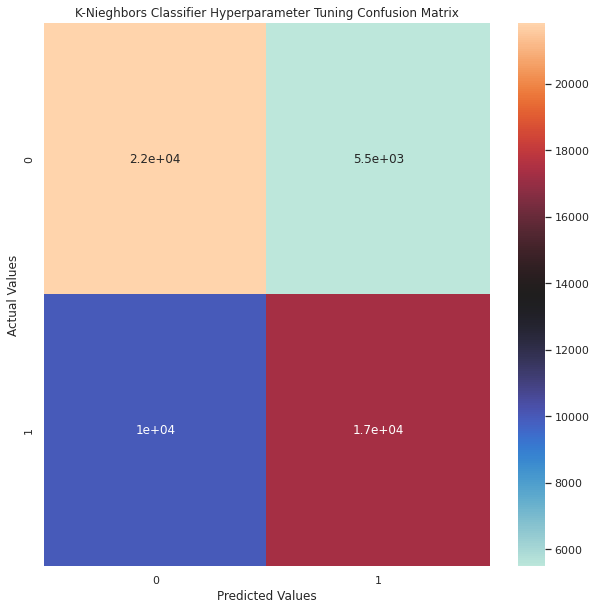

In [113]:
plt.figure(figsize=(10, 10))
plt.title("K-Nieghbors Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_knn_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

### RandomForest Classifier


In [114]:
model_rfc=RandomForestClassifier(n_jobs= -1, max_depth = 15, min_samples_split= 5, 
                                 random_state= 10, n_estimators= 200)

model_rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=200,
                       n_jobs=-1, random_state=10)

In [115]:
y_pred_rfc = model_rfc.predict(X_test)

In [116]:
train_acc_rfc = model_rfc.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_rfc*100))

The Accuracy for Training Set is 79.57712205057952


In [117]:
test_acc_rfc = accuracy_score(y_test, y_pred_rfc)
print("The Accuracy for Test Set is {}".format(test_acc_rfc*100))

The Accuracy for Test Set is 78.6331198536139


In [118]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

       False       0.70      0.99      0.82     27325
        True       0.98      0.58      0.73     27325

    accuracy                           0.79     54650
   macro avg       0.84      0.79      0.78     54650
weighted avg       0.84      0.79      0.78     54650



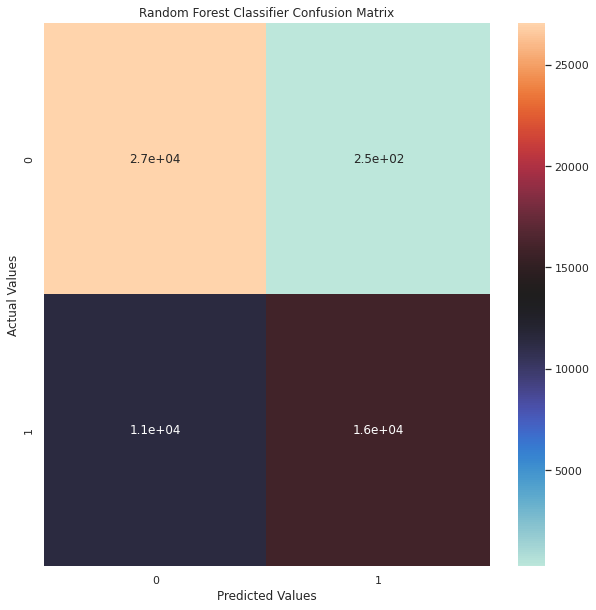

In [119]:
plt.figure(figsize=(10,10))
plt.title("Random Forest Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_rfc), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

####Hyperparamter Tuning

In [120]:
def objective(trial):

    max_depth =  trial.suggest_int('max_depth', 20, 25, log = True)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 5, 10)
    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    
  

    rfc = RandomForestClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf,
                                 n_estimators = n_estimators, criterion = criterion,
                                 random_state = 10, n_jobs= -1)

    score = cross_val_score(rfc, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-01-14 05:57:26,878] A new study created in memory with name: no-name-fcf1273e-c179-4b5a-a782-a74b159070f5
[I 2023-01-14 05:59:16,394] Trial 0 finished with value: 0.7872181100340525 and parameters: {'max_depth': 21, 'min_samples_leaf': 5, 'n_estimators': 200, 'criterion': 'gini'}. Best is trial 0 with value: 0.7872181100340525.
[I 2023-01-14 06:02:40,581] Trial 1 finished with value: 0.7877498676988622 and parameters: {'max_depth': 22, 'min_samples_leaf': 6, 'n_estimators': 297, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7877498676988622.
[I 2023-01-14 06:05:45,163] Trial 2 finished with value: 0.7876867733731011 and parameters: {'max_depth': 22, 'min_samples_leaf': 5, 'n_estimators': 258, 'criterion': 'entropy'}. Best is trial 1 with value: 0.7877498676988622.
[I 2023-01-14 06:10:29,637] Trial 3 finished with value: 0.7879571475706152 and parameters: {'max_depth': 25, 'min_samples_leaf': 7, 'n_estimators': 398, 'criterion': 'entropy'}. Best is trial 3 with value: 0

In [121]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.7882816176466556
Best hyperparameters: {'max_depth': 23, 'min_samples_leaf': 7, 'n_estimators': 332, 'criterion': 'entropy'}


In [122]:
optuna.visualization.plot_optimization_history(study)

In [123]:
optuna.visualization.plot_slice(study)

In [124]:
best_params = trial.params
best_params

{'max_depth': 23,
 'min_samples_leaf': 7,
 'n_estimators': 332,
 'criterion': 'entropy'}

In [125]:
model_rfc_hp = RandomForestClassifier(**best_params, n_jobs = -1, random_state= 10)
model_rfc_hp.fit(X_train, y_train) 

RandomForestClassifier(criterion='entropy', max_depth=23, min_samples_leaf=7,
                       n_estimators=332, n_jobs=-1, random_state=10)

In [126]:
y_pred_rfc_hp = model_rfc_hp.predict(X_test)

In [127]:
train_acc_rfc_hp = model_rfc_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_rfc_hp*100))

The Accuracy for Training Set is 80.04668601402383


In [128]:
test_acc_rfc_hp = accuracy_score(y_test, y_pred_rfc_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_rfc_hp*100))

The Accuracy for Test Set is 78.98993595608417


In [129]:
print(classification_report(y_test, y_pred_rfc_hp))

              precision    recall  f1-score   support

       False       0.71      0.99      0.82     27325
        True       0.98      0.59      0.74     27325

    accuracy                           0.79     54650
   macro avg       0.84      0.79      0.78     54650
weighted avg       0.84      0.79      0.78     54650



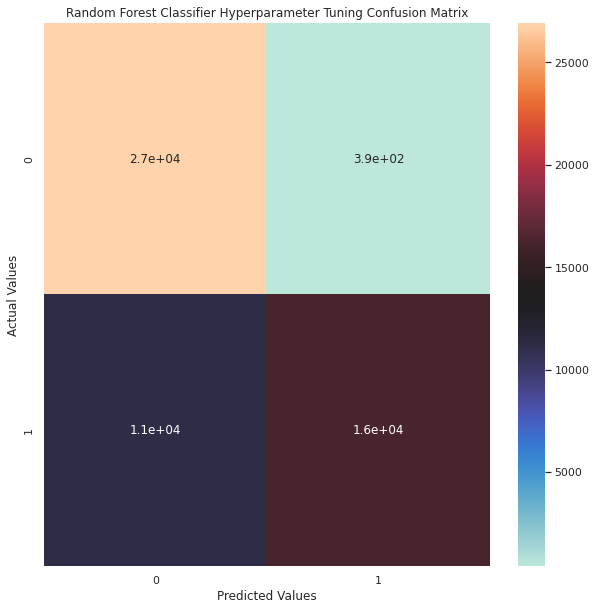

In [130]:
plt.figure(figsize=(10,10))
plt.title("Random Forest Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_rfc_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

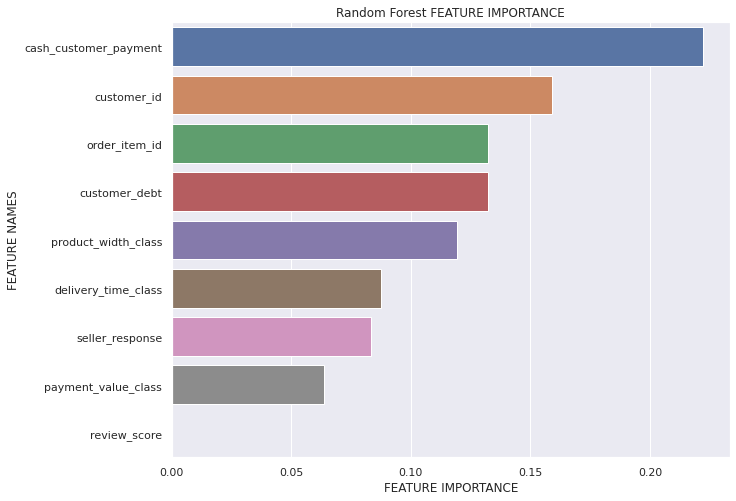

In [131]:
plot_feature_importance(model_rfc_hp.feature_importances_, X_filtered.columns, 'Random Forest')

### Light Gradient Boosting Machine

In [132]:
model_lgbm = LGBMClassifier(device = 'cpu', objective =  'binary', n_estimators = 200,
                            eval_metric =  'logloss', num_leaves =  63, learning_rate =  0.01,
                            depth = 6, n_jobs = -1, random_state = 10)

model_lgbm.fit(X_train, y_train)

LGBMClassifier(depth=6, device='cpu', eval_metric='logloss', learning_rate=0.01,
               n_estimators=200, num_leaves=63, objective='binary',
               random_state=10)

In [133]:
y_pred_lgbm = model_lgbm.predict(X_test)

In [134]:
train_acc_lgbm = model_lgbm.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_lgbm*100))

The Accuracy for Training Set is 78.35769778466752


In [135]:
test_acc_lgbm = accuracy_score(y_test, y_pred_lgbm) 
print("The Accuracy for Test Set is {}".format(test_acc_lgbm*100))

The Accuracy for Test Set is 78.47941445562671


In [136]:
print(classification_report(y_test, y_pred_lgbm))

              precision    recall  f1-score   support

       False       0.70      1.00      0.82     27325
        True       1.00      0.57      0.73     27325

    accuracy                           0.78     54650
   macro avg       0.85      0.78      0.77     54650
weighted avg       0.85      0.78      0.77     54650



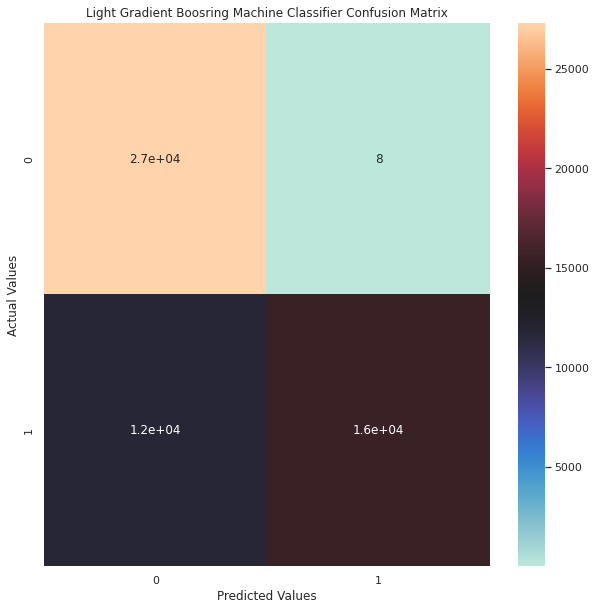

In [137]:
plt.figure(figsize=(10,10))
plt.title("Light Gradient Boosring Machine Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_lgbm), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

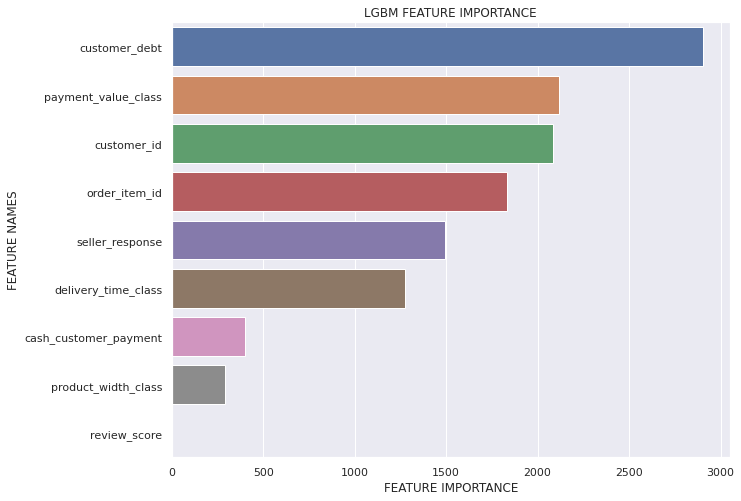

In [138]:
plot_feature_importance(model_lgbm.feature_importances_, X_filtered.columns, 'LGBM')

####Hyperparamter Tuning

In [139]:
def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 200, 400)
    depth =  trial.suggest_int('depth', 8, 14)
    num_leaves = trial.suggest_int('num_leaves', 2, 5)

  

    lgbm = LGBMClassifier(num_leaves = num_leaves, n_estimators = n_estimators, depth = depth,
                          device = "cpu", objective =  'binary', eval_metric =  'logloss', 
                          n_jobs = -1, random_state = 10)

    score = cross_val_score(lgbm, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-01-14 06:49:59,435] A new study created in memory with name: no-name-79de5662-c7ea-4df1-822a-28cad5745325
[I 2023-01-14 06:50:05,892] Trial 0 finished with value: 0.777871899924757 and parameters: {'n_estimators': 211, 'depth': 10, 'num_leaves': 3}. Best is trial 0 with value: 0.777871899924757.
[I 2023-01-14 06:50:14,750] Trial 1 finished with value: 0.7831533755580038 and parameters: {'n_estimators': 234, 'depth': 9, 'num_leaves': 5}. Best is trial 1 with value: 0.7831533755580038.
[I 2023-01-14 06:50:22,700] Trial 2 finished with value: 0.7832705405804483 and parameters: {'n_estimators': 251, 'depth': 10, 'num_leaves': 5}. Best is trial 2 with value: 0.7832705405804483.
[I 2023-01-14 06:50:30,845] Trial 3 finished with value: 0.7628927349550725 and parameters: {'n_estimators': 335, 'depth': 9, 'num_leaves': 2}. Best is trial 2 with value: 0.7832705405804483.
[I 2023-01-14 06:50:37,693] Trial 4 finished with value: 0.7791517065704443 and parameters: {'n_estimators': 241, 'dep

In [140]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.7840636670908385
Best hyperparameters: {'n_estimators': 374, 'depth': 14, 'num_leaves': 5}


In [141]:
optuna.visualization.plot_optimization_history(study)

In [142]:
optuna.visualization.plot_slice(study)

In [143]:
best_params = trial.params
best_params

{'n_estimators': 374, 'depth': 14, 'num_leaves': 5}

In [144]:
model_lgbm_hp = LGBMClassifier(**best_params, device = "cpu", objective =  'binary',
                               eval_metric =  'logloss', n_jobs = -1, random_state = 10)

model_lgbm_hp.fit(X_train, y_train)

LGBMClassifier(depth=14, device='cpu', eval_metric='logloss', n_estimators=374,
               num_leaves=5, objective='binary', random_state=10)

In [145]:
y_pred_lgbm_hp = model_lgbm_hp.predict(X_test)

In [146]:
train_acc_lgbm_hp = model_lgbm_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_lgbm_hp*100))

The Accuracy for Training Set is 78.43250356003388


In [147]:
test_acc_lgbm_hp = accuracy_score(y_test, y_pred_lgbm_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_lgbm_hp*100))

The Accuracy for Test Set is 78.55260750228729


In [148]:
print(classification_report(y_test, y_pred_lgbm_hp))

              precision    recall  f1-score   support

       False       0.70      1.00      0.82     27325
        True       1.00      0.57      0.73     27325

    accuracy                           0.79     54650
   macro avg       0.85      0.79      0.78     54650
weighted avg       0.85      0.79      0.78     54650



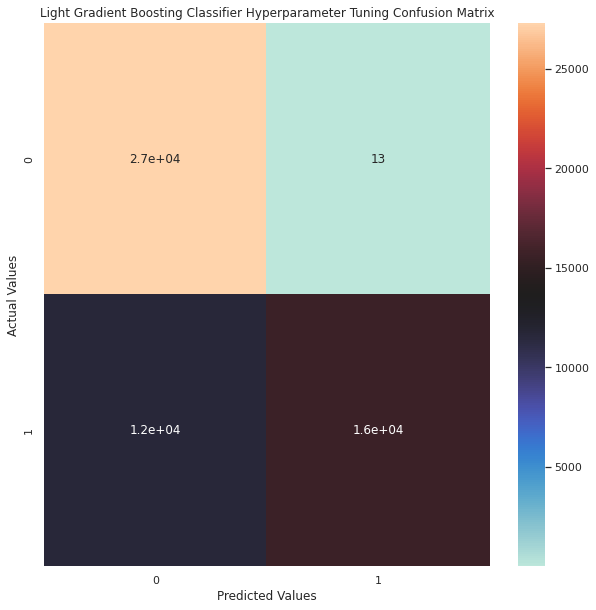

In [149]:
plt.figure(figsize=(10,10))
plt.title("Light Gradient Boosting Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_lgbm_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

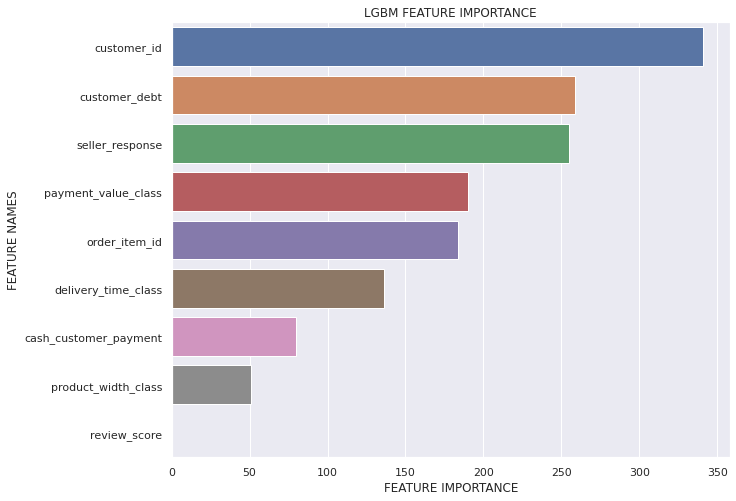

In [150]:
plot_feature_importance(model_lgbm_hp.feature_importances_, X_filtered.columns, 'LGBM')

### Extreme Gradient Boosting

In [161]:
model_xgb = XGBClassifier(max_depth =  3, eta = 1, objective =  'binary:logistic', n_jobs = -1, random_state = 10)

model_xgb.fit(X_train, y_train)

XGBClassifier(eta=1, n_jobs=-1, random_state=10)

In [162]:
y_pred_xgb = model_xgb.predict(X_test)

In [164]:
train_acc_xgb = model_xgb.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_xgb*100))

The Accuracy for Training Set is 78.16212123943257


In [165]:
test_acc_xgb = accuracy_score(y_test, y_pred_xgb) 
print("The Accuracy for Test Set is {}".format(test_acc_xgb*100))

The Accuracy for Test Set is 78.28545288197621


In [166]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

       False       0.70      1.00      0.82     27325
        True       1.00      0.57      0.72     27325

    accuracy                           0.78     54650
   macro avg       0.85      0.78      0.77     54650
weighted avg       0.85      0.78      0.77     54650



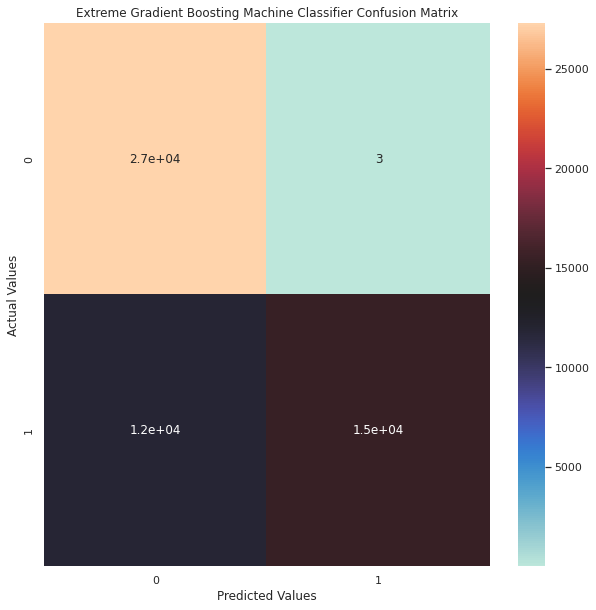

In [167]:
plt.figure(figsize=(10,10))
plt.title("Extreme Gradient Boosting Machine Classifier Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_xgb), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

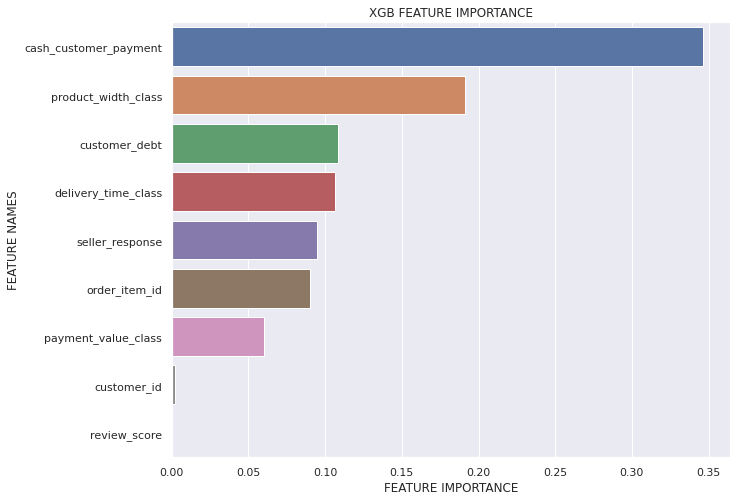

In [168]:
plot_feature_importance(model_xgb.feature_importances_, X_filtered.columns, 'XGB')

####Hyperparamter Tuning

In [169]:
def objective(trial):

    min_child_weight = trial.suggest_int('min_child_weight', 5, 10)
    max_depth =  trial.suggest_int('max_depth', 5, 10)
    sampling_method = trial.suggest_categorical("sampling_method", ["uniform", "gradient_based"])

  

    xgb = XGBClassifier(min_child_weight = min_child_weight, max_depth  = max_depth , sampling_method = sampling_method,
                           eta = 1, objective =  'binary:logistic', n_jobs = -1, random_state = 10)

    score = cross_val_score(xgb, X_train, y_train, n_jobs = -1, cv = 5)

    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 15)

[I 2023-01-14 07:21:21,588] A new study created in memory with name: no-name-feae5f52-9b31-4a65-bf4f-7d89d1350434
[I 2023-01-14 07:22:29,901] Trial 0 finished with value: 0.7855417519117741 and parameters: {'min_child_weight': 8, 'max_depth': 6, 'sampling_method': 'gradient_based'}. Best is trial 0 with value: 0.7855417519117741.
[I 2023-01-14 07:23:20,895] Trial 1 finished with value: 0.7855868168503651 and parameters: {'min_child_weight': 10, 'max_depth': 6, 'sampling_method': 'uniform'}. Best is trial 1 with value: 0.7855868168503651.
[I 2023-01-14 07:24:26,070] Trial 2 finished with value: 0.7889485579424761 and parameters: {'min_child_weight': 7, 'max_depth': 10, 'sampling_method': 'gradient_based'}. Best is trial 2 with value: 0.7889485579424761.
[I 2023-01-14 07:25:22,139] Trial 3 finished with value: 0.7888494283995828 and parameters: {'min_child_weight': 5, 'max_depth': 9, 'sampling_method': 'uniform'}. Best is trial 2 with value: 0.7889485579424761.
[I 2023-01-14 07:26:07,835

In [170]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.7892820366197202
Best hyperparameters: {'min_child_weight': 6, 'max_depth': 10, 'sampling_method': 'gradient_based'}


In [171]:
optuna.visualization.plot_optimization_history(study)

In [172]:
optuna.visualization.plot_slice(study)

In [173]:
best_params = trial.params
best_params

{'min_child_weight': 6, 'max_depth': 10, 'sampling_method': 'gradient_based'}

In [177]:
model_xgb_hp = XGBClassifier(**best_params, eta = 1, objective =  'binary:logistic',
                             n_jobs = -1, random_state = 10)

model_xgb_hp.fit(X_train, y_train)

XGBClassifier(eta=1, max_depth=10, min_child_weight=6, n_jobs=-1,
              random_state=10, sampling_method='gradient_based')

In [178]:
y_pred_xgb_hp = model_xgb_hp.predict(X_test)

In [179]:
train_acc_xgb_hp = model_xgb_hp.score(X_train, y_train)
print("The Accuracy for Training Set is {}".format(train_acc_xgb_hp*100))

The Accuracy for Training Set is 79.55999783694143


In [180]:
test_acc_xgb_hp = accuracy_score(y_test, y_pred_xgb_hp) 
print("The Accuracy for Test Set is {}".format(test_acc_xgb_hp*100))

The Accuracy for Test Set is 79.09606587374199


In [181]:
print(classification_report(y_test, y_pred_xgb_hp))

              precision    recall  f1-score   support

       False       0.71      0.99      0.83     27325
        True       0.99      0.59      0.74     27325

    accuracy                           0.79     54650
   macro avg       0.85      0.79      0.78     54650
weighted avg       0.85      0.79      0.78     54650



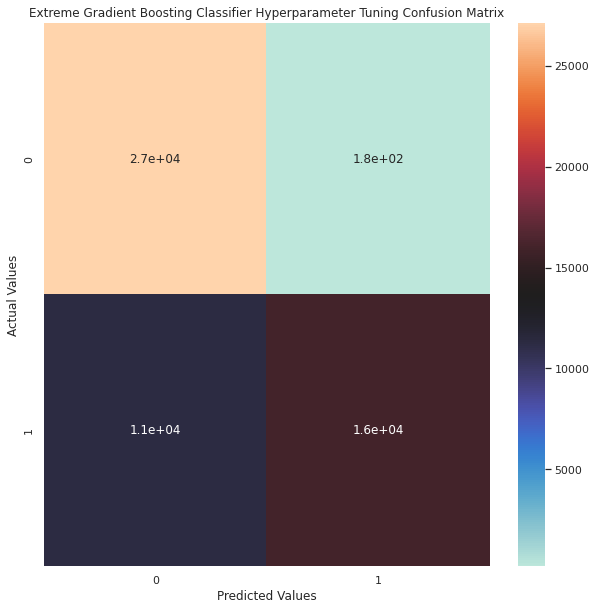

In [182]:
plt.figure(figsize=(10,10))
plt.title("Extreme Gradient Boosting Classifier Hyperparameter Tuning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_xgb_hp), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

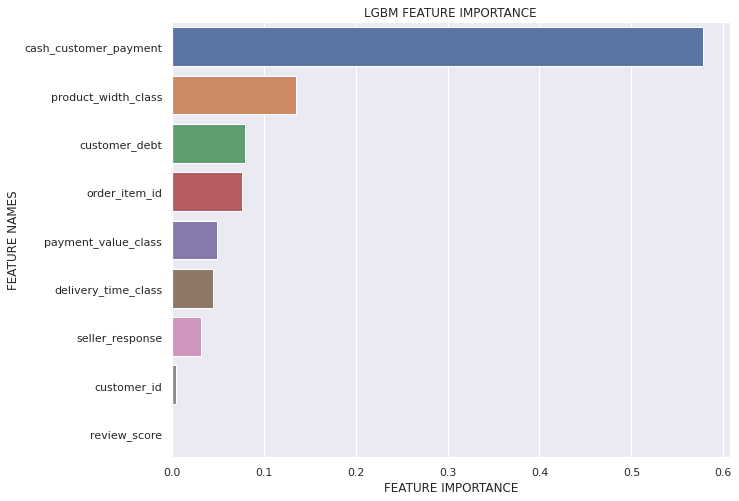

In [183]:
plot_feature_importance(model_xgb_hp.feature_importances_, X_filtered.columns, 'LGBM')

###Ensemble All Models

In [185]:
model_vote = VotingClassifier(estimators = [('knn', model_knn_hp), ('rfc', model_rfc_hp), 
                                            ('lgbm', model_lgbm_hp), ('xgb', model_xgb_hp)],
                               voting = 'hard')

In [187]:
for model in (model_knn_hp, model_rfc_hp, model_lgbm_hp, model_xgb_hp, model_vote):
  model.fit(X_train, y_train)
  y_pred_vote = model.predict(X_test)
  train_acc_model = model.score(X_train, y_train)
  test_acc_model = accuracy_score(y_test, y_pred_vote) 

In [188]:
print("The Accuracy for Training Set is {}".format(train_acc_model*100))

The Accuracy for Training Set is 79.28510914433008


In [189]:
print("The Accuracy for Test Set is {}".format(test_acc_model*100))

The Accuracy for Test Set is 79.14547118023788


In [190]:
print(classification_report(y_test, y_pred_vote))

              precision    recall  f1-score   support

       False       0.71      1.00      0.83     27325
        True       1.00      0.58      0.74     27325

    accuracy                           0.79     54650
   macro avg       0.85      0.79      0.78     54650
weighted avg       0.85      0.79      0.78     54650



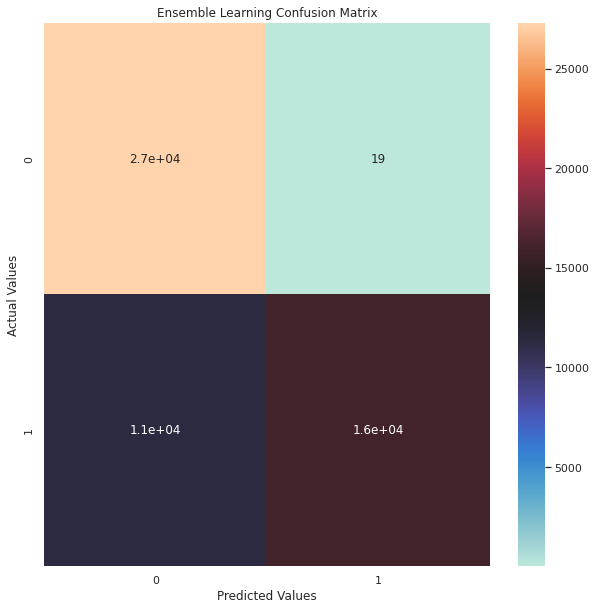

In [191]:
plt.figure(figsize=(10,10))
plt.title("Ensemble Learning Confusion Matrix")
sns.heatmap(confusion_matrix(y_test,y_pred_vote), annot = True, cmap ='icefire')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

### Accuracy of models implimented

In [192]:
print("The Accuracy of KNighborsClassifier w/ HP for Test Set is {}".format(test_acc_knn_hp*100))
print("The Accuracy of RandomForestClassifier w/ HP  for Test Set is {}".format(test_acc_rfc_hp*100))
print("The Accuracy of LGBMClassifier w/ HP  for Test Set is {}".format(test_acc_lgbm_hp*100))
print("The Accuracy of XGBClassifier w/ HPT for Test Set is {}".format(test_acc_xgb_hp*100))
print("The Accuracy of Ensemble Learning for Test Set is {}".format(test_acc_model*100))

The Accuracy of KNighborsClassifier w/ HP for Test Set is 71.69807868252516
The Accuracy of RandomForestClassifier w/ HP  for Test Set is 78.98993595608417
The Accuracy of LGBMClassifier w/ HP  for Test Set is 78.55260750228729
The Accuracy of XGBClassifier w/ HPT for Test Set is 79.09606587374199
The Accuracy of Ensemble Learning for Test Set is 79.14547118023788


##6. Save Best Model


In [194]:
filename = 'prop_churn_model.p'

In [195]:
pickle.dump(model, open(filename, 'wb'))